<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Double_Well_2D/Models/%5BFINAL%5Dvariational_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install FEniCS and mshr
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-12-01 19:20:08--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-12-01 19:20:08 (8.72 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f62c6f6/releases/pybi

In [2]:
# Imports & FP64
import gc
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from fenics import *
import mshr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Solving for the MET of a given SDE in an ellipse with "Boundary Adapted PINNs": comparison with FEM solution

## 1) Setup

For $a=2$ and $b=1.5$, let $
\Omega := \{ (x,y)\in\mathbb{R}^2 : (x/a)^2 + (y/b)^2 < 1 \}$ be the ellipse centered at the origin with semi-axes $a$ (along $x$) and $b$ (along $y$). We consider a process driven by the double-well potential

$$
\Phi(x,y):= A\Bigl( 1-\exp\Bigl(-\frac{(x-1)^2+(y-0.5)^2}{\nu^2}\Bigr)\Bigr)
\Bigl( 1-\exp\Bigl(-\frac{(x+1)^2+(y+0.5)^2}{\nu^2}\Bigr)\Bigr),
$$  
with parameters $A>0$ (which controls the barrier height) and $\nu>0$ (which controls the width of the wells). Its associated drift is given by the negative gradient,
$$
b(x,y)= -\nabla\Phi(x,y)= \begin{pmatrix} b_1(x,y) \\ b_2(x,y) \end{pmatrix}.
$$

The stochastic differential equation solved by our process takes the form
$$
\begin{cases}
dX_t = b(X_t)\,dt + \sigma(X_t)\,dW_t,\\
X_0 = x\in\Omega,
\end{cases}
$$  
where the diffusion matrix is chosen as  
$$
\sigma(x,y)= \begin{pmatrix}
\sqrt{2\epsilon} & 0 \\
0 & \sqrt{\epsilon}
\end{pmatrix}
$$  
for some $\epsilon>0$, and $W_t$ is a two-dimensional standard Brownian motion.

For all $x\in\Omega$, we define the exit time
$$
T(x):=\inf\{t\ge 0: X_t\in\partial\Omega\},
$$  
and denote by
$$
\tau(x):=\mathbb{E}[T(x)]
$$  
its first moment (the mean exit time).

In this setting, one can show that $\tau$ is the (unique) solution of the boundary value problem
$$
\begin{cases}
-\mathcal{L} u(x) = 1 \quad \text{for all } x\in\Omega,\\[1mm]
u(x)= 0 \quad \text{for all } x\in\partial\Omega,
\end{cases}
$$  
where the infinitesimal generator $\mathcal{L}$ is given by
$$
\mathcal{L} u(x) = \epsilon\, u_{xx}(x) + \frac\epsilon2\, u_{yy}(x) + b_1(x,y)\, u_x(x) + b_2(x,y)\, u_y(x).
$$

**Derivation of the Weak Formulation:**

Multiplying the strong form of the PDE
$$
\epsilon\, u_{xx} + \frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y = -1 \quad \text{in } \Omega,
$$  
by a test function $v\in H^1_0(\Omega)$ and integrating over $\Omega$, we obtain
$$
\int_\Omega \Bigl[ \epsilon\, u_{xx} +\frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y \Bigr] v\,dx\,dy = -\int_\Omega v\,dx\,dy.
$$  
Integration by parts on the second derivative terms (with $v=0$ on $\partial\Omega$) yields
$$
\int_\Omega \Bigl(\epsilon\, u_x\, v_x + \frac\epsilon2\, u_y\, v_y \Bigr) dx\,dy - \int_\Omega \Bigl( b_1\, u_x + b_2\, u_y \Bigr) v\,dx\,dy = \int_\Omega v\,dx\,dy.
$$  
This is the weak formulation that we discretize using a Galerkin finite element method.

## Approximating the true solution with FEM

In [3]:
# Parameters controlling the double-well potential and diffusion.
#numpy version
A_np = 5.0      # Barrier height for the double-well potential
nu_np = 1e-1    # Width parameter of the wells in the potential
eps_np = 12e-1   # Diffusion parameter
#fenics version
A = Constant(A_np)
nu = Constant(nu_np)
epsilon = Constant(eps_np)

# Create the elliptical domain Omega
a = 2.0
b = 1.5
domain = mshr.Ellipse(Point(0.0, 0.0), a, b)
mesh = mshr.generate_mesh(domain, 64)

# FE function space and boundary conditions
V = FunctionSpace(mesh, "CG", 1)

# Homogeneous Dirichlet BC (u = 0 on the boundary)
u_D = Constant(0.0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define the double-well potential and drift field
# using the spatial coordinates (x,y) from the mesh
x_coord = SpatialCoordinate(mesh)

# Double-well potential defined by:
#   Φ(x,y) = A [1 - exp(-((x-1)²+(y-0.5)²)/ν²)] [1 - exp(-((x+1)²+(y+0.5)²)/ν²)]
Phi = A * (1 - exp(-(((x_coord[0]-1)**2 + (x_coord[1]-0.5)**2) / (nu**2)))) \
        * (1 - exp(-(((x_coord[0]+1)**2 + (x_coord[1]+0.5)**2) / (nu**2))))

# The drift b(x,y) is the negative gradient of the potential.
db = -grad(Phi)
b1 = db[0]
b2 = db[1]

# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)

# The weak formulation reads:
# (ε u_x v_x + (ε/2) u_y v_y) dx - (b₁ u_x + b₂ u_y) v dx = ∫_Ω v dx

a_form = (epsilon * u.dx(0) * v.dx(0) + (epsilon/2) * u.dx(1) * v.dx(1)
          - (b1 * u.dx(0) + b2 * u.dx(1)) * v) * dx
L_form = v * dx

# Solve the problem
u_sol = Function(V)
solve(a_form == L_form, u_sol, bc)

# ------------------------
# Now u_h is the finite element solution (function of x and y)
# Example: Evaluating the solution at a specific point (x0, y0):
# pt = (0.0, 0.0)  # Example point at the center of the domain
# value_at_pt = u_sol(pt)
# print("The solution u_sol at point {} is: {}".format(pt, value_at_pt))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00477386 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.20944 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_30dfdfb9b755d02bb430ce4cd11df0f47d817129

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0349085 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00163293 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00983262 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00203633 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00765705 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_26ffa5436f46d7160897b4ecbf02274ede43bb85

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    3
  Coefficients:              '[f_0, f_1, f_2]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00178862 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00976419 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

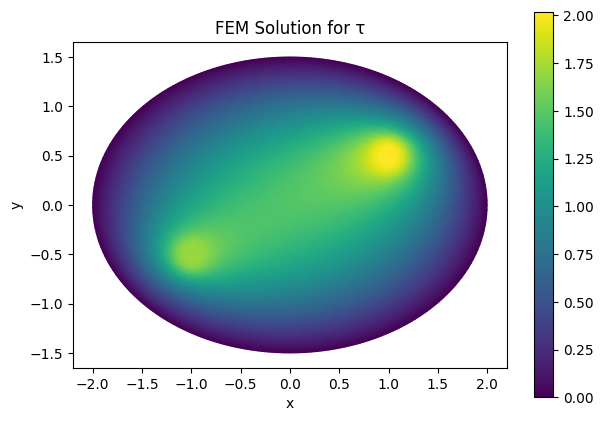

In [4]:
# plotting the solution
plt.figure(figsize=(7, 5))
p = plot(u_sol, title="FEM Solution for τ", mode="color")
plt.colorbar(p)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# plotting the mesh to see how the ellipse was discretized
# plt.figure(figsize=(7, 5))
# plot(mesh)
# plt.title("Mesh for the Elliptical Domain")
# plt.show()

## Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{\omega(x)}{\sqrt{\omega(x)^2 + \|\nabla\omega(x)\|^2}},$$
where
$$\omega(x,y) = 1 - \left(\frac{x}{a}\right)^2 - \left(\frac{y}{b}\right)^2,\ \ \text{and }\ \ \|\nabla\omega(x,y)\|^2 = \left(\frac{2x}{a^2}\right)^2 + \left(\frac{2y}{b^2}\right)^2 $$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$, and the hypothesis space is given by
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma \circ T_{L-1}\circ\cdots\circ \sigma\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma :x \mapsto \begin{cases}x^2 &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} \quad \text{OR }\ \ \sigma : x\mapsto \operatorname{tanh}(x),$$
is either the ReQU or hyperbolic tangent activation function, which is understood element-wise when applied to vectors.

In [5]:
# defining PINN w/ matching boundary condition
power = None #exponent k for relu^k, none for tanh
width = 30
depth = 3
gain = 2.0 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)

#define hypothesis space
class VariationalPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(VariationalPINN,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        if isinstance(power, int):
            self.layers.append(RePU(power))
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(RePU(power))
        else :
            self.layers.append(nn.Tanh())
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(width, 1))
        self.mlp = nn.Sequential(*self.layers)

        #for dynamic weighting
        self.log_sigma_pde = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))
        self.log_sigma_data = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))
        self.log_sigma_bc = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))

    def forward(self, x):
        return self.mlp(x)

#weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(gain)

In [6]:
# Variational residual with Nitsche's method (weak form + BC enforcement)
def variational_residual(model, X_int, X_bd, c_test, s_test, A, nu, epsilon, a=2.0, b=1.5):
    """
    Compute average squared variational residual over Gaussian test functions.
    Includes Nitsche terms for Dirichlet BC u=0 on boundary.
    """

    # Compute ellipse perimeter using Ramanujan's approximation
    h = ((a - b) / (a + b)) ** 2
    arclen = math.pi * (a + b) * (1 + (3 * h) / (10 + math.sqrt(4 - 3 * h)))

    X_int = X_int.detach().requires_grad_(True)
    X_bd = X_bd.detach().requires_grad_(True)

    # Interior points
    u_int = model(X_int)
    grad_u_int = torch.autograd.grad(u_int.sum(), X_int, create_graph=True)[0]  # [N,2]

    # Unpack coordinates for drift computation (detach to exclude from graph)
    X_int_det = X_int.detach()  # Frozen copy for fixed drift b(x)
    xs = X_int_det[:, 0]  # [N]
    ys = X_int_det[:, 1]  # [N]

    # Squared distances to well centers
    d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
    d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2

    # Exponential terms
    exp1 = torch.exp(-d1_sq / (nu**2))  # e1
    exp2 = torch.exp(-d2_sq / (nu**2))  # e2

    # f1 = 1 - exp1, f2 = 1 - exp2
    f1 = 1.0 - exp1
    f2 = 1.0 - exp2

    # --- Compute ∇Φ analytically ---
    # ∂f1/∂x = (2/ν²)(x-1) exp1
    df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
    df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1

    df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
    df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

    # ∇Φ = A * (∇f1 * f2 + f1 * ∇f2)
    dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
    dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

    # drift b = -∇Φ (now detached, not in graph)
    b1 = -dPhi_dx
    b2 = -dPhi_dy

    # Test functions φ_k and ∇φ_k on interior
    dx_int = X_int[:, None, :] - c_test[None, :, :]  # [N, K, 2]
    dist_sq_int = torch.sum(dx_int**2, dim=-1)       # [N, K]
    phi_int = torch.exp(-dist_sq_int / (2 * s_test**2))
    grad_phi_int = -dx_int / (s_test**2) * phi_int[..., None]  # [N, K, 2]

    # Test functions on boundary
    dx_bd = X_bd[:, None, :] - c_test[None, :, :]
    dist_sq_bd = torch.sum(dx_bd**2, dim=-1)
    phi_bd = torch.exp(-dist_sq_bd / (2 * s_test**2))
    grad_phi_bd = -dx_bd / (s_test**2) * phi_bd[..., None]

    # Diffusion coefficients
    A_x = epsilon
    A_y = epsilon / 2.0
    area = math.pi * a * b

    # Bilinear form diffusion part: ∫ ∇u · A ∇φ dx ≈ mean(∇u · A ∇φ) * area
    # Optimized: Use einsum for efficient anisotropic dot product
    dot_grad = (A_x * grad_u_int[:, None, 0] * grad_phi_int[:, :, 0] +
                A_y * grad_u_int[:, None, 1] * grad_phi_int[:, :, 1])  # [N, K]

    # Drift term: -∫ (b · ∇u) φ dx ≈ -mean((b · ∇u) φ) * area
    # Optimized: Compute b · ∇u first, then broadcast/multiply
    b_dot_gradu = (b1 * grad_u_int[:, 0] + b2 * grad_u_int[:, 1])[:, None] * phi_int  # [N, K]
    drift_term = -b_dot_gradu.mean(0) * area  # [K]

    a_k = dot_grad.mean(0) * area + drift_term  # [K]

    # Linear form l(φ_k) = ∫ 1 * φ_k dx
    F_k = phi_int.mean(0) * area  # [K]

    # Boundary: outward unit normal for ellipse
    nx = X_bd[:, 0] / (a ** 2)
    ny = X_bd[:, 1] / (b ** 2)
    norm_n = torch.sqrt(nx ** 2 + ny ** 2)
    n_x = nx / norm_n
    n_y = ny / norm_n

    # Nitsche consistency term: -∫ (A ∇u · n) φ ds
    u_bd = model(X_bd)
    grad_u_bd = torch.autograd.grad(u_bd.sum(), X_bd, create_graph=True)[0]  # [M,2]
    A_gradu_n = (A_x * grad_u_bd[:, 0] * n_x + A_y * grad_u_bd[:, 1] * n_y)  # [M]
    consistency_k = - (A_gradu_n[:, None] * phi_bd).mean(0) * arclen  # [K]

    # Nitsche symmetry term: -∫ u (A ∇φ · n) ds
    # Optimized: Precompute A ∇φ · n broadcasting
    A_gradphi_n_x = A_x * grad_phi_bd[:, :, 0] * n_x[:, None, None]
    A_gradphi_n_y = A_y * grad_phi_bd[:, :, 1] * n_y[:, None, None]
    A_gradphi_n = (A_gradphi_n_x + A_gradphi_n_y).squeeze(-1)  # [M, K]
    symmetry_k = - (u_bd[:, None] * A_gradphi_n).mean(0) * arclen  # [K]

    # Nitsche penalty term: +β ∫ u φ ds  (g=0), raw without β
    raw_penalty_k = (u_bd[:, None] * phi_bd).mean(0) * arclen  # [K]

    # Total variational residual per test function (without penalty)
    r_interior_k = a_k - F_k + consistency_k + symmetry_k   # <-- only this line changed (RHS sign)
    return r_interior_k, raw_penalty_k

def var_loss_fn(r_k):
    return torch.mean(r_k.pow(2))

## Computing an approximate data penalty regularization

We sample a small subset $x_1, \ldots, x_{n_{d}} \in \Omega$ of points for which we compute approximate values $\tau^{MC}(x_1), \ldots, \tau^{MC}(x_{n_{d}}) $ by Monte Carlo. we will then use them to define a "data-fidelity" penalty term in the loss function:
$$\text{Penalty}(\hat\tau_{NN}) = \frac{\lambda_{d}}{n_{d}} \sum_{i=1}^{n_d} \left(\tau^{MC}(x_i) - \hat\tau_{NN}(x_i)\right)^2, $$
where $\lambda_{d}$ is a positive regularization parameter.

In [7]:
# generating some approximate true solutions in the domain

# sampling anchor points, uniform in the ellipse
@torch.no_grad()
def sample_ellipse(batch_size, a=2.0, b=1.5):
    """
    Sample uniformly in the ellipse: (x/a)^2 + (y/b)^2 <= 1.
    Uses rejection sampling in the bounding box [-a,a] x [-b,b].
    """
    collected = []  # List of [num_in, 2] tensors
    needed = batch_size
    while needed > 0:
        x = (2 * torch.rand(batch_size, device=device) - 1) * a  # [-a, a]
        y = (2 * torch.rand(batch_size, device=device) - 1) * b  # [-b, b]
        inside = (x/a)**2 + (y/b)**2 <= 1.0
        points_in = torch.stack([x[inside], y[inside]], dim=1)  # [num_in, 2]
        collected.append(points_in)
        needed -= points_in.shape[0]

    all_points = torch.cat(collected, dim=0)  # [total >= batch_size, 2]
    if all_points.shape[0] > batch_size:
        idx = torch.randperm(all_points.shape[0], device=device)[:batch_size]
        all_points = all_points[idx]
    return all_points


# 2) monte-carlo (euler-maruyama) approximation of tau at these points
@torch.no_grad()
def mc_exit_time(x0, A, nu, epsilon,
                 n_paths=128, dt=1e-3, max_steps=20000):
    """
    x0: [B,2] starting points
    Returns tau_hat: [B] = mean exit time from each x0.
    Any path still 'alive' after max_steps is counted as having exit time = max_steps*dt.
    """
    B = x0.shape[0]
    P = n_paths

    # Expand to per-path positions — CONTIGUOUS
    X = x0.unsqueeze(1).expand(B, P, 2).contiguous()  # [B,P,2]
    t = torch.zeros(B, P, device=device)
    alive = torch.ones(B, P, dtype=torch.bool, device=device)

    # Precompute diffusion
    dt_t = torch.as_tensor(dt, device=device, dtype=torch.float32)
    epsilon_t = torch.as_tensor(epsilon, device=device, dtype=torch.float32)
    sqrt_dt_x = torch.sqrt(2 * epsilon_t * dt_t)
    sqrt_dt_y = torch.sqrt(epsilon_t * dt_t)
    #sqrt_dt_x = (2 * epsilon * dt)**0.5
    #sqrt_dt_y = (epsilon * dt)**0.5

    print_interval = max(1, max_steps // 100)  # at most 100 updates

    # --- Main loop: work on FULL batch, mask updates ---
    for step in range(max_steps):
        if not alive.any():
            break

        # Work on full [B,P,2] tensor — fully vectorized
        xs = X[..., 0]  # [B,P]
        ys = X[..., 1]  # [B,P]

        # --- Double-well drift: fully vectorized ---
        d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
        d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2
        exp1 = torch.exp(-d1_sq / nu**2)
        exp2 = torch.exp(-d2_sq / nu**2)
        f1 = 1.0 - exp1
        f2 = 1.0 - exp2

        df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
        df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1
        df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
        df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

        dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
        dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

        drift_x = -dPhi_dx * dt
        drift_y = -dPhi_dy * dt

        # Noise: full batch
        noise_x = sqrt_dt_x * torch.randn_like(xs)
        noise_y = sqrt_dt_y * torch.randn_like(ys)

        # Update ONLY alive paths
        X[..., 0] += drift_x
        X[..., 1] += drift_y
        X[..., 0][~alive] -= drift_x[~alive]  # undo
        X[..., 1][~alive] -= drift_y[~alive]  # undo
        X[..., 0] += noise_x
        X[..., 1] += noise_y
        X[..., 0][~alive] -= noise_x[~alive]
        X[..., 1][~alive] -= noise_y[~alive]

        t += dt
        t[~alive] -= dt  # don't advance time for dead paths

        # Check exit on full batch
        exited = (X[..., 0]/a)**2 + (X[..., 1]/b)**2 >= 1.0
        just_exited = exited & alive
        alive[just_exited] = False

        if step % print_interval == 0 or step == max_steps - 1:
            frac_alive = alive.float().mean().item()
            current_t = step * dt
            print(f"Step {step} | t = {current_t:.2f} | alive: {frac_alive*100:.3f}%", flush=True)


    tau_hat = t.mean(dim=1)  # [B]
    return tau_hat

In [8]:
def sample_boundary(N, a=2.0, b=1.5):
    """
    Uniform sampling on the boundary of the ellipse: (x/a)^2 + (y/b)^2 = 1
    Parameterized by angle θ ∈ [0, 2π)
    """
    theta = 2 * math.pi * torch.rand(N, device=device)
    x = a * torch.cos(theta)
    y = b * torch.sin(theta)
    return torch.stack([x, y], dim=1)  # [N,2]

## Training Loop

### Training Parameters

In [9]:
# Training parameters
pool_size        = 8192
n_batches        = 16
batch_size       = pool_size // n_batches
n_epochs         = 5_000
learning_rate    = 5e-4

# model instantiation
model = VariationalPINN(power, width, depth).to(device)
model.apply(init_weights)

opt   = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

# scheduler: every `epochs_between_decays` epochs, multiply lr by gamma
num_decays = 100
epochs_between_decay = n_epochs // num_decays
final_factor = 1e-3
gamma = np.exp(np.log(final_factor) / num_decays)

scheduler = torch.optim.lr_scheduler.StepLR(
    opt,
    step_size=epochs_between_decay,  # decay every N epochs
    gamma=gamma                      # LR *= gamma at each decay
)

In [10]:
# Test function centers and hyperparameters
K_test = 50
area = math.pi * a * b
s_test = area / 10.0
c_test = sample_ellipse(K_test)
h = ((a - b) / (a + b)) ** 2
arclen = math.pi * (a + b) * (1 + (3 * h) / (10 + math.sqrt(4 - 3 * h)))

### Generating the "data-fidelity" samples

In [11]:
# sample x_data
x_data = sample_ellipse(batch_size//2)

max_time = 15
dt = 2e-4

# precompute tau_data once
tau_data = mc_exit_time(
    x0       = x_data,
    A        = A_np,
    nu       = nu_np,
    epsilon  = eps_np,
    n_paths  = 256,
    dt       = dt,
    max_steps= int(max_time / dt)
)

Step 0 | t = 0.00 | alive: 99.365%
Step 750 | t = 0.15 | alive: 60.550%
Step 1500 | t = 0.30 | alive: 48.044%
Step 2250 | t = 0.45 | alive: 39.581%
Step 3000 | t = 0.60 | alive: 33.330%
Step 3750 | t = 0.75 | alive: 28.137%
Step 4500 | t = 0.90 | alive: 23.950%
Step 5250 | t = 1.05 | alive: 20.447%
Step 6000 | t = 1.20 | alive: 17.415%
Step 6750 | t = 1.35 | alive: 14.888%
Step 7500 | t = 1.50 | alive: 12.813%
Step 8250 | t = 1.65 | alive: 11.014%
Step 9000 | t = 1.80 | alive: 9.486%
Step 9750 | t = 1.95 | alive: 8.134%
Step 10500 | t = 2.10 | alive: 7.024%
Step 11250 | t = 2.25 | alive: 6.090%
Step 12000 | t = 2.40 | alive: 5.261%
Step 12750 | t = 2.55 | alive: 4.555%
Step 13500 | t = 2.70 | alive: 3.928%
Step 14250 | t = 2.85 | alive: 3.404%
Step 15000 | t = 3.00 | alive: 2.896%
Step 15750 | t = 3.15 | alive: 2.507%
Step 16500 | t = 3.30 | alive: 2.164%
Step 17250 | t = 3.45 | alive: 1.889%
Step 18000 | t = 3.60 | alive: 1.619%
Step 18750 | t = 3.75 | alive: 1.384%
Step 19500 | t = 3

### Starting the training with Adam

In [12]:
# Training Loop w/ Loss Logging

# prep for best‐model tracking
best_loss       = float("inf")
adam_model_path = "best_adam.pth"
best_epoch = 0
eval_Xb = sample_ellipse(pool_size) #to evaluate the model
eval_xbc = sample_boundary(pool_size//4)

total_history = []
pde_history   = []
data_history  = []
bc_history    = []

model.train()
for ep in range(1, n_epochs+1):

    opt.zero_grad()

    X_int = sample_ellipse(batch_size)
    X_bd = sample_boundary(batch_size)

    r_interior_k, penalty_k = variational_residual(model, X_int, X_bd, c_test, s_test, A_np, nu_np, eps_np)
    loss_var = var_loss_fn(r_interior_k)
    loss_bc  = var_loss_fn(penalty_k)

    # data‐loss (fixed x_data, tau_data)
    tau_pred = model(x_data)
    loss_data = (tau_pred - tau_data).pow(2).mean()

    # total + backward + step
    loss_total = (torch.exp(-2 * model.log_sigma_pde) * loss_var
               + torch.exp(-2 * model.log_sigma_data) * loss_data
               + torch.exp(-2 * model.log_sigma_bc) * loss_bc
               + model.log_sigma_pde
               + model.log_sigma_data
               + model.log_sigma_bc
    )

    # 6) backward + step
    loss_total.backward()
    opt.step()
    scheduler.step()

    #eval
    r_k_eval, bc_eval = variational_residual(model, eval_Xb, eval_xbc, c_test, s_test, A_np, nu_np, eps_np)
    loss_eval = var_loss_fn(r_k_eval) + var_loss_fn(bc_eval)

    del r_k_eval, bc_eval

    if loss_eval < best_loss or ep - best_epoch >= epochs_between_decay * 10 :
        best_loss = loss_eval
        torch.save(model.state_dict(), adam_model_path)
        best_epoch = ep

    # 7) logging & histories
    #total_history.append(loss_total.item())
    total_history.append(loss_total.item() \
                            - (model.log_sigma_pde.detach()\
                            + model.log_sigma_data.detach()\
                            + model.log_sigma_bc.detach() ).item())
    pde_history.append(loss_var.item())
    data_history.append(loss_data.item())
    bc_history.append(loss_bc.item())

    if ep % 100 == 0:
        print(
            f"[ep {ep:4d}/{n_epochs}] "
            f"loss_pde={loss_var:.2e}  "
            f"loss_data={loss_data:.2e}  "
            f"loss_bc={loss_bc:.2e}  "
        )
    if ep % 500 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"  → epoch {ep:4d},  lr={lr:.2e}")

    del X_int, X_bd  # Explicit del (frees tensors immediately)
    gc.collect()     # Force garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

[ep  100/5000] loss_pde=1.19e+00  loss_data=2.52e-01  loss_bc=5.20e-04  
[ep  200/5000] loss_pde=6.31e-01  loss_data=2.22e-01  loss_bc=1.62e-04  
[ep  300/5000] loss_pde=1.27e-01  loss_data=2.15e-01  loss_bc=1.27e-03  
[ep  400/5000] loss_pde=8.76e-02  loss_data=2.12e-01  loss_bc=3.77e-03  
[ep  500/5000] loss_pde=3.00e-01  loss_data=2.10e-01  loss_bc=3.34e-03  
  → epoch  500,  lr=2.51e-04
[ep  600/5000] loss_pde=5.02e-02  loss_data=2.10e-01  loss_bc=3.81e-04  
[ep  700/5000] loss_pde=1.36e-01  loss_data=2.08e-01  loss_bc=3.09e-03  
[ep  800/5000] loss_pde=1.31e-01  loss_data=2.10e-01  loss_bc=4.16e-04  
[ep  900/5000] loss_pde=4.29e-02  loss_data=2.07e-01  loss_bc=3.82e-03  
[ep 1000/5000] loss_pde=1.81e-01  loss_data=2.09e-01  loss_bc=1.03e-03  
  → epoch 1000,  lr=1.26e-04
[ep 1100/5000] loss_pde=8.34e-02  loss_data=2.06e-01  loss_bc=4.11e-03  
[ep 1200/5000] loss_pde=4.48e-01  loss_data=2.06e-01  loss_bc=8.19e-04  
[ep 1300/5000] loss_pde=5.33e-02  loss_data=2.05e-01  loss_bc=7.54

### L-BFGS Fine Tuning

In [13]:
#LBFGS fine-tuning

# Reload best Adam snapshot
print(f"\nLoading best Adam model (loss={best_loss:.3e}, epoch={best_epoch}) …")
model.load_state_dict(torch.load(adam_model_path))
model.to(device)


# define L-BFGS parameters
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter= 3*n_epochs,
    history_size=500,
    tolerance_grad = 0,
    tolerance_change = 0,
    line_search_fn="strong_wolfe"
)

max_eval = lbfgs.defaults.get('max_eval')

# freeze one big PDE batch for the closure
Xb_ft = sample_ellipse(pool_size)
x_bc_ft = sample_boundary(pool_size//4)

lbfgs_total = []
lbfgs_pde   = []
lbfgs_data  = []
lbfgs_bc    = []

#closure function
def closure():
    closure.calls += 1
    lbfgs.zero_grad()

    #PDE and BC
    r_k, bc_k = variational_residual(model, Xb_ft, x_bc_ft, c_test, s_test, A_np, nu_np, eps_np)
    loss_var = var_loss_fn(r_k)
    loss_bc  = var_loss_fn(bc_k)

    # data term
    tau_p   = model(x_data).squeeze(-1)
    data_l  = (tau_p - tau_data).pow(2).mean()

    #total
    total_l = (torch.exp(-2 * model.log_sigma_pde) * loss_var
            + torch.exp(-2 * model.log_sigma_data) * data_l
            + torch.exp(-2 * model.log_sigma_bc)   * loss_bc
            + model.log_sigma_pde
            + model.log_sigma_data
            + model.log_sigma_bc
    )
    # record
    #lbfgs_total.append(total_l.item())
    lbfgs_total.append(total_l.item() - \
            (model.log_sigma_pde.detach() + model.log_sigma_data
             + model.log_sigma_bc.detach()).item())
    lbfgs_pde.append(loss_var.item())
    lbfgs_data.append(data_l.item())
    lbfgs_bc.append(loss_bc.item())

    total_l.backward()

    del r_k, bc_k
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    PRINT_EVERY = 100
    if closure.calls % PRINT_EVERY == 0:
        print(
            f"eval {closure.calls}/{max_eval} | "
            f"loss pde {loss_var:.2e} | "
            f"loss boundary {loss_bc:.2e} | "
            f"loss data {data_l:.2e}"
        )
    return total_l

closure.calls = 0


Loading best Adam model (loss=2.890e-02, epoch=4984) …


In [14]:
# report losses before/after lbfgs
# make sure model is in eval mode so e.g. Dropout/BatchNorm won’t move
model.eval()

# PDE loss
r_k_before, bc_before = variational_residual(model, Xb_ft, x_bc_ft, c_test, s_test, A_np, nu_np, eps_np)
before_var = var_loss_fn(r_k_before).item()
before_bc =  var_loss_fn(bc_before).item()

# data loss (doesn't need grads)
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    before_data = (tau_p - tau_data).pow(2).mean()

print(f"Before L-BFGS → PDE {before_var:.3e}, DATA {before_data:.3e}, , BC: {before_bc:.3e}")#, SOBOLEV {before_h2:.2e})

# running L-BFGS
print("→ Running L-BFGS...")
loss_after = lbfgs.step(closure)
print(f"L-BFGS did {closure.calls} closure calls, final total loss = {loss_after:.2e}")

Before L-BFGS → PDE 1.873e-02, DATA 6.149e-02, , BC: 1.272e-03
→ Running L-BFGS...
eval 100/18750 | loss pde 2.49e-03 | loss boundary 1.89e-05 | loss data 3.77e-02
eval 200/18750 | loss pde 6.29e-04 | loss boundary 4.18e-08 | loss data 6.33e-02
eval 300/18750 | loss pde 8.68e-05 | loss boundary 2.67e-10 | loss data 5.86e-02
eval 400/18750 | loss pde 4.86e-05 | loss boundary 3.21e-11 | loss data 4.31e-02
eval 500/18750 | loss pde 4.01e-05 | loss boundary 4.05e-11 | loss data 4.24e-02
eval 600/18750 | loss pde 2.72e-05 | loss boundary 1.75e-09 | loss data 4.64e-02
eval 700/18750 | loss pde 1.20e-05 | loss boundary 1.49e-11 | loss data 6.73e-02
eval 800/18750 | loss pde 9.40e-06 | loss boundary 1.21e-11 | loss data 6.75e-02
eval 900/18750 | loss pde 8.79e-06 | loss boundary 1.61e-11 | loss data 6.31e-02
eval 1000/18750 | loss pde 8.15e-06 | loss boundary 3.61e-12 | loss data 6.21e-02
eval 1100/18750 | loss pde 7.49e-06 | loss boundary 1.52e-10 | loss data 5.70e-02
eval 1200/18750 | loss p

In [15]:
# after L-BFGS, same pattern:
model.eval()
r_k_after, bc_after = variational_residual(model, Xb_ft, x_bc_ft, c_test, s_test, A_np, nu_np, eps_np)
after_var = var_loss_fn(r_k_after).item()
after_bc = var_loss_fn(bc_after).item()
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    after_data = (tau_p - tau_data).pow(2).mean()
print(f" After L-BFGS → PDE {after_var:.3e}, DATA {after_data:.3e}, BC: {after_bc:.3e}")

# saving the L-BFGS fine-tuned model
lbfgs_model_path = 'lbfgs_finetuned.pth'
torch.save(model.state_dict(), lbfgs_model_path)

 After L-BFGS → PDE 1.387e-08, DATA 9.245e-02, BC: 4.160e-16


## Plotting the Results

### Training Curves

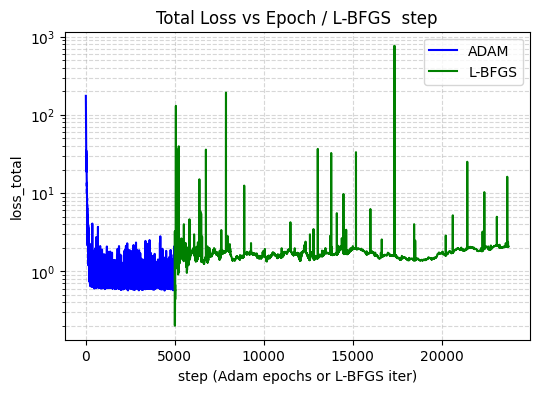

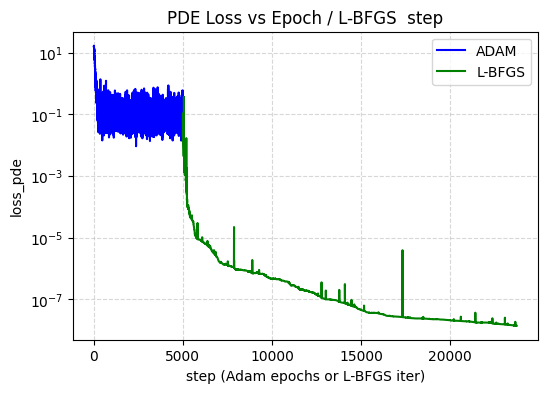

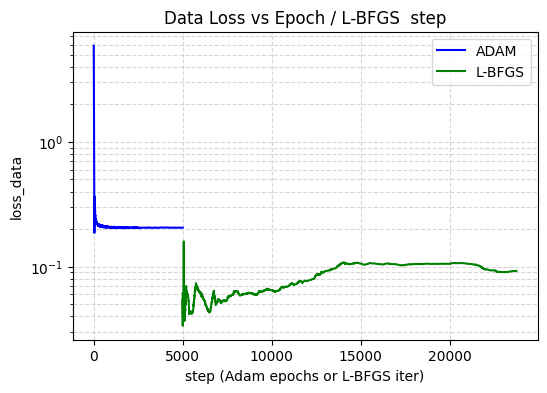

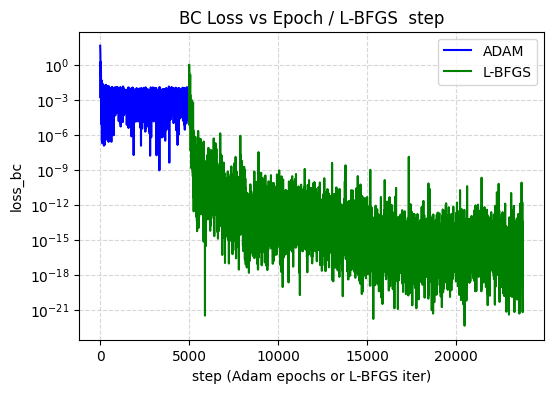

In [16]:
# --------------------------------------------------------------
#  Plotting three separate loss evolutions
# --------------------------------------------------------------
adam_end   = n_epochs
lbfgs_end  = adam_end + len(lbfgs_total)

total_history = total_history + lbfgs_total
pde_history   = pde_history   + lbfgs_pde
data_history  = data_history  + lbfgs_data
bc_history    = bc_history    + lbfgs_bc

# a) Total Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), total_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), total_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.title("Total Loss vs Epoch / L-BFGS  step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_total")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# b) PDE Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), pde_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), pde_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.title("PDE Loss vs Epoch / L-BFGS  step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_pde")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# c) Data Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), data_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), data_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.title("Data Loss vs Epoch / L-BFGS  step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# c) BC Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(adam_end), bc_history[:adam_end], color='blue', label="ADAM")
plt.semilogy(np.arange(adam_end, lbfgs_end), bc_history[adam_end:lbfgs_end], color='green', label="L-BFGS")
plt.title("BC Loss vs Epoch / L-BFGS  step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_bc")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Learned Solution vs FEM Solution

In [17]:
# Choose model to evaluate

choice = 2 #input("Enter 1, 2 or 3: ").strip()

model = VariationalPINN(power, width, depth)
if choice == 1:
    model.load_state_dict(torch.load(adam_model_path))
    print("Loaded Adam-only model")
elif choice == 2:
    model.load_state_dict(torch.load(lbfgs_model_path))
    print("Loaded L-BFGS fine-tuned model")
else:
    raise ValueError("Invalid choice")

model.to(device)
model.eval()

Loaded L-BFGS fine-tuned model


VariationalPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
)

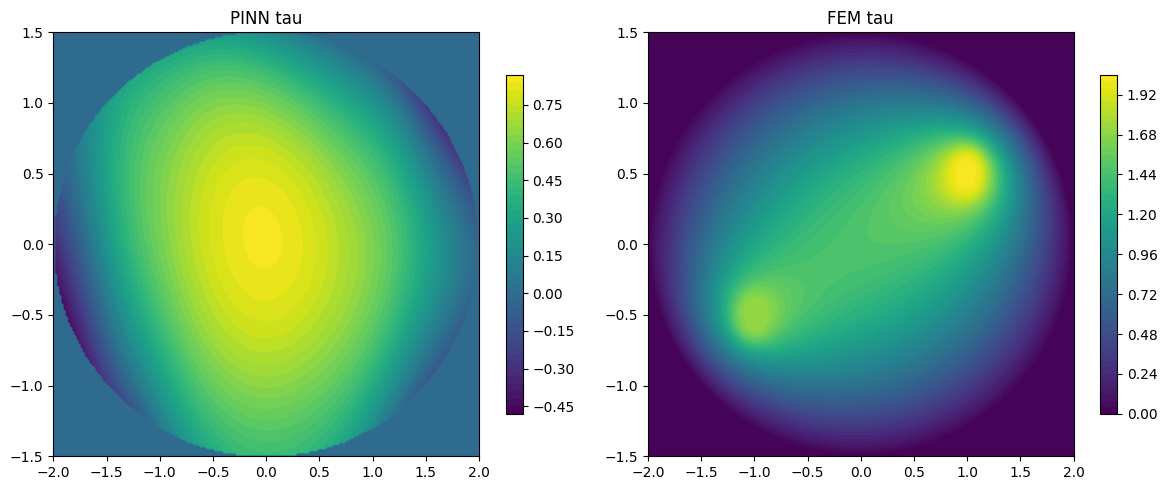

In [18]:
#Visualize PINN vs True tau

n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-a,a,n_pts),
    np.linspace(-b,b,n_pts)
)
mask = (xx/a)**2 + (yy/b)**2 <= 1.0
pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    inp = torch.from_numpy(pts).to(device)
    pred = model(inp).cpu().numpy().squeeze(-1)

Zp = np.zeros_like(xx); Zt = np.zeros_like(xx)
Zp[mask] = pred
Zt[mask] = np.array([u_sol(x, y) for x, y in pts])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
cf1 = ax1.contourf(xx, yy, Zp, levels=50, cmap='viridis')
ax1.set_title('PINN tau')
fig.colorbar(cf1, ax=ax1, shrink=0.8)

cf2 = ax2.contourf(xx, yy, Zt, levels=50, cmap='viridis')
ax2.set_title('FEM tau')
fig.colorbar(cf2, ax=ax2, shrink=0.8)
plt.tight_layout()
plt.show()

### Relative and Pointwise error

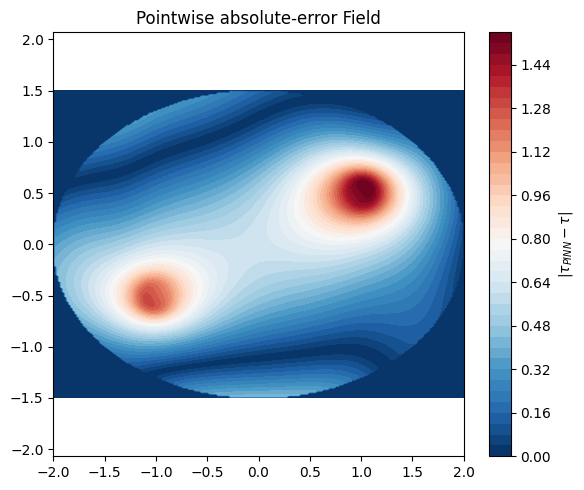

In [19]:
# pointwise L1 error
Z_err = np.abs(Zp - Zt)
plt.figure(figsize=(6,5))
cf = plt.contourf(xx, yy, Z_err, levels=50, cmap='RdBu_r')
plt.colorbar(cf, label=r'$|\tau_{PINN}-\tau|$')
plt.title('Pointwise absolute‐error Field')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
# average relative L2 error
#    ‖tau_pinn − tau_true‖₂ / ‖tau_true‖₂   (empirical L²(Ω) norm)
pred_vals = pred
true_vals = np.array([u_sol(x, y) for x, y in pts])

# Empirical L² norm of true solution: √( (1/n) Σ τ_true² )
tau_l2_norm = np.sqrt(np.mean(true_vals**2))
glob_rel_L2 = np.sqrt(np.mean((pred_vals - true_vals)**2)) / tau_l2_norm
print(f"Global relative L2 error: {glob_rel_L2:.3e} (true solution L2 norm: {tau_l2_norm:.3e})")

# average relative L1 error
#     ‖tau_pinn − tau_true‖₁ / ‖tau_true‖₁   (empirical L¹(Ω) norm)
tau_l1_norm = np.mean(np.abs(true_vals))
glob_rel_L1 = np.mean(np.abs(pred_vals - true_vals)) / tau_l1_norm
print(f"Global relative L1 error: {glob_rel_L1:.3e} (true solution L1 norm: {tau_l1_norm:.3e})")

# Sobolev H1 and H2 errors (finite difference on full grid)

# Compute grid spacings in x and y for the ellipse:
dx = (2 * a) / (n_pts - 1)
dy = (2 * b) / (n_pts - 1)

# Error field on the full grid
Z_err = Zp - Zt

# First derivatives of the error field using finite differences
derr_dy, derr_dx = np.gradient(Z_err, dy, dx)
grad_err_sq = derr_dx[mask]**2 + derr_dy[mask]**2

# Second derivatives of the error field
d2err_dx2 = np.gradient(derr_dx, dx, axis=1)
d2err_dy2 = np.gradient(derr_dy, dy, axis=0)
d2err_dxdy = np.gradient(derr_dy, dx, axis=1)
hess_err_sq = d2err_dx2[mask]**2 + d2err_dy2[mask]**2 + 2 * d2err_dxdy[mask]**2

# Compute derivatives for the true solution field (Zt) on the full grid
dt_dy, dt_dx = np.gradient(Zt, dy, dx)
grad_t_sq = dt_dx[mask]**2 + dt_dy[mask]**2

d2t_dx2 = np.gradient(dt_dx, dx, axis=1)
d2t_dy2 = np.gradient(dt_dy, dy, axis=0)
d2t_dxdy = np.gradient(dt_dy, dx, axis=1)
hess_t_sq = d2t_dx2[mask]**2 + d2t_dy2[mask]**2 + 2 * d2t_dxdy[mask]**2

# Compute the H¹ and H² norms of the true solution
tau_h1_norm = np.sqrt(np.mean(Zt[mask]**2 + grad_t_sq))
tau_h2_norm = np.sqrt(np.mean(Zt[mask]**2 + grad_t_sq + hess_t_sq))

# Global relative Sobolev error metrics
glob_rel_H1 = np.sqrt(np.mean(Z_err[mask]**2 + grad_err_sq)) / tau_h1_norm
glob_rel_H2 = np.sqrt(np.mean(Z_err[mask]**2 + grad_err_sq + hess_err_sq)) / tau_h2_norm

print(f"Global relative H1 error: {glob_rel_H1:.3e} (true solution H1 norm: {tau_h1_norm:.3e})")
print(f"Global relative H2 error: {glob_rel_H2:.3e} (true solution H2 norm: {tau_h2_norm:.3e})")

print(f"Final PDE loss: {after_var:.3e}")
print(f"Final BC loss: {after_bc:.3e}")
print(f"Final data loss: {after_data:.3e}")

Global relative L2 error: 5.444e-01 (true solution L2 norm: 9.538e-01)
Global relative L1 error: 5.190e-01 (true solution L1 norm: 8.125e-01)
Global relative H1 error: 9.162e-01 (true solution H1 norm: 1.834e+00)
Global relative H2 error: 7.984e+00 (true solution H2 norm: 8.577e+00)
Final PDE loss: 1.387e-08
Final BC loss: 4.160e-16
Final data loss: 9.245e-02


In [21]:
np.save('pde_history_variational.npy', np.array(pde_history))
np.save('data_history_variational.npy', np.array(data_history))